In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
pd.options.display.max_columns = 999
pd.options.display.max_columns = 999
from sklearn.preprocessing import LabelEncoder

import warnings 
warnings.filterwarnings('ignore')

path = '/Users/ppangppang/Desktop/dacon/airline_dataset/'
data = pd.read_csv(path+'data/train.csv')
test = pd.read_csv(path+'data/test.csv')
submission = pd.read_csv(path+'data/sample_submission.csv')
data = data.drop('id',axis=1)
test = test.drop('id',axis=1)

# 데이터 EDA

In [5]:
data

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target
0,Female,disloyal Customer,22,Business travel,Eco,1599,3,0,3,3,4,3,4,4,5,4,4,4,5,4,0,0.0,0
1,Female,Loyal Customer,37,Business travel,Business,2810,2,4,4,4,1,4,3,5,5,4,2,1,5,2,18,18.0,0
2,Male,Loyal Customer,46,Business travel,Business,2622,1,1,1,1,4,5,5,4,4,4,4,5,4,3,0,0.0,1
3,Female,disloyal Customer,24,Business travel,Eco,2348,3,3,3,3,3,3,3,3,2,4,5,3,4,3,10,2.0,0
4,Female,Loyal Customer,58,Business travel,Business,105,3,3,3,3,4,4,5,4,4,4,4,4,4,5,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Male,Loyal Customer,30,Personal Travel,Eco,2377,1,5,1,1,1,4,4,1,3,5,3,4,2,4,211,225.0,0
2996,Female,disloyal Customer,24,Business travel,Eco,1643,2,4,3,4,5,3,5,5,2,2,4,1,3,5,20,13.0,0
2997,Female,disloyal Customer,22,Business travel,Eco,1442,2,2,2,3,4,2,4,4,3,2,3,4,3,4,64,67.0,0
2998,Female,disloyal Customer,33,Business travel,Business,2158,2,2,2,5,4,2,4,4,5,2,5,5,5,4,0,3.0,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             3000 non-null   object 
 1   Customer Type                      3000 non-null   object 
 2   Age                                3000 non-null   int64  
 3   Type of Travel                     3000 non-null   object 
 4   Class                              3000 non-null   object 
 5   Flight Distance                    3000 non-null   int64  
 6   Seat comfort                       3000 non-null   int64  
 7   Departure/Arrival time convenient  3000 non-null   int64  
 8   Food and drink                     3000 non-null   int64  
 9   Gate location                      3000 non-null   int64  
 10  Inflight wifi service              3000 non-null   int64  
 11  Inflight entertainment             3000 non-null   int64

## 데이터 분포 시각화

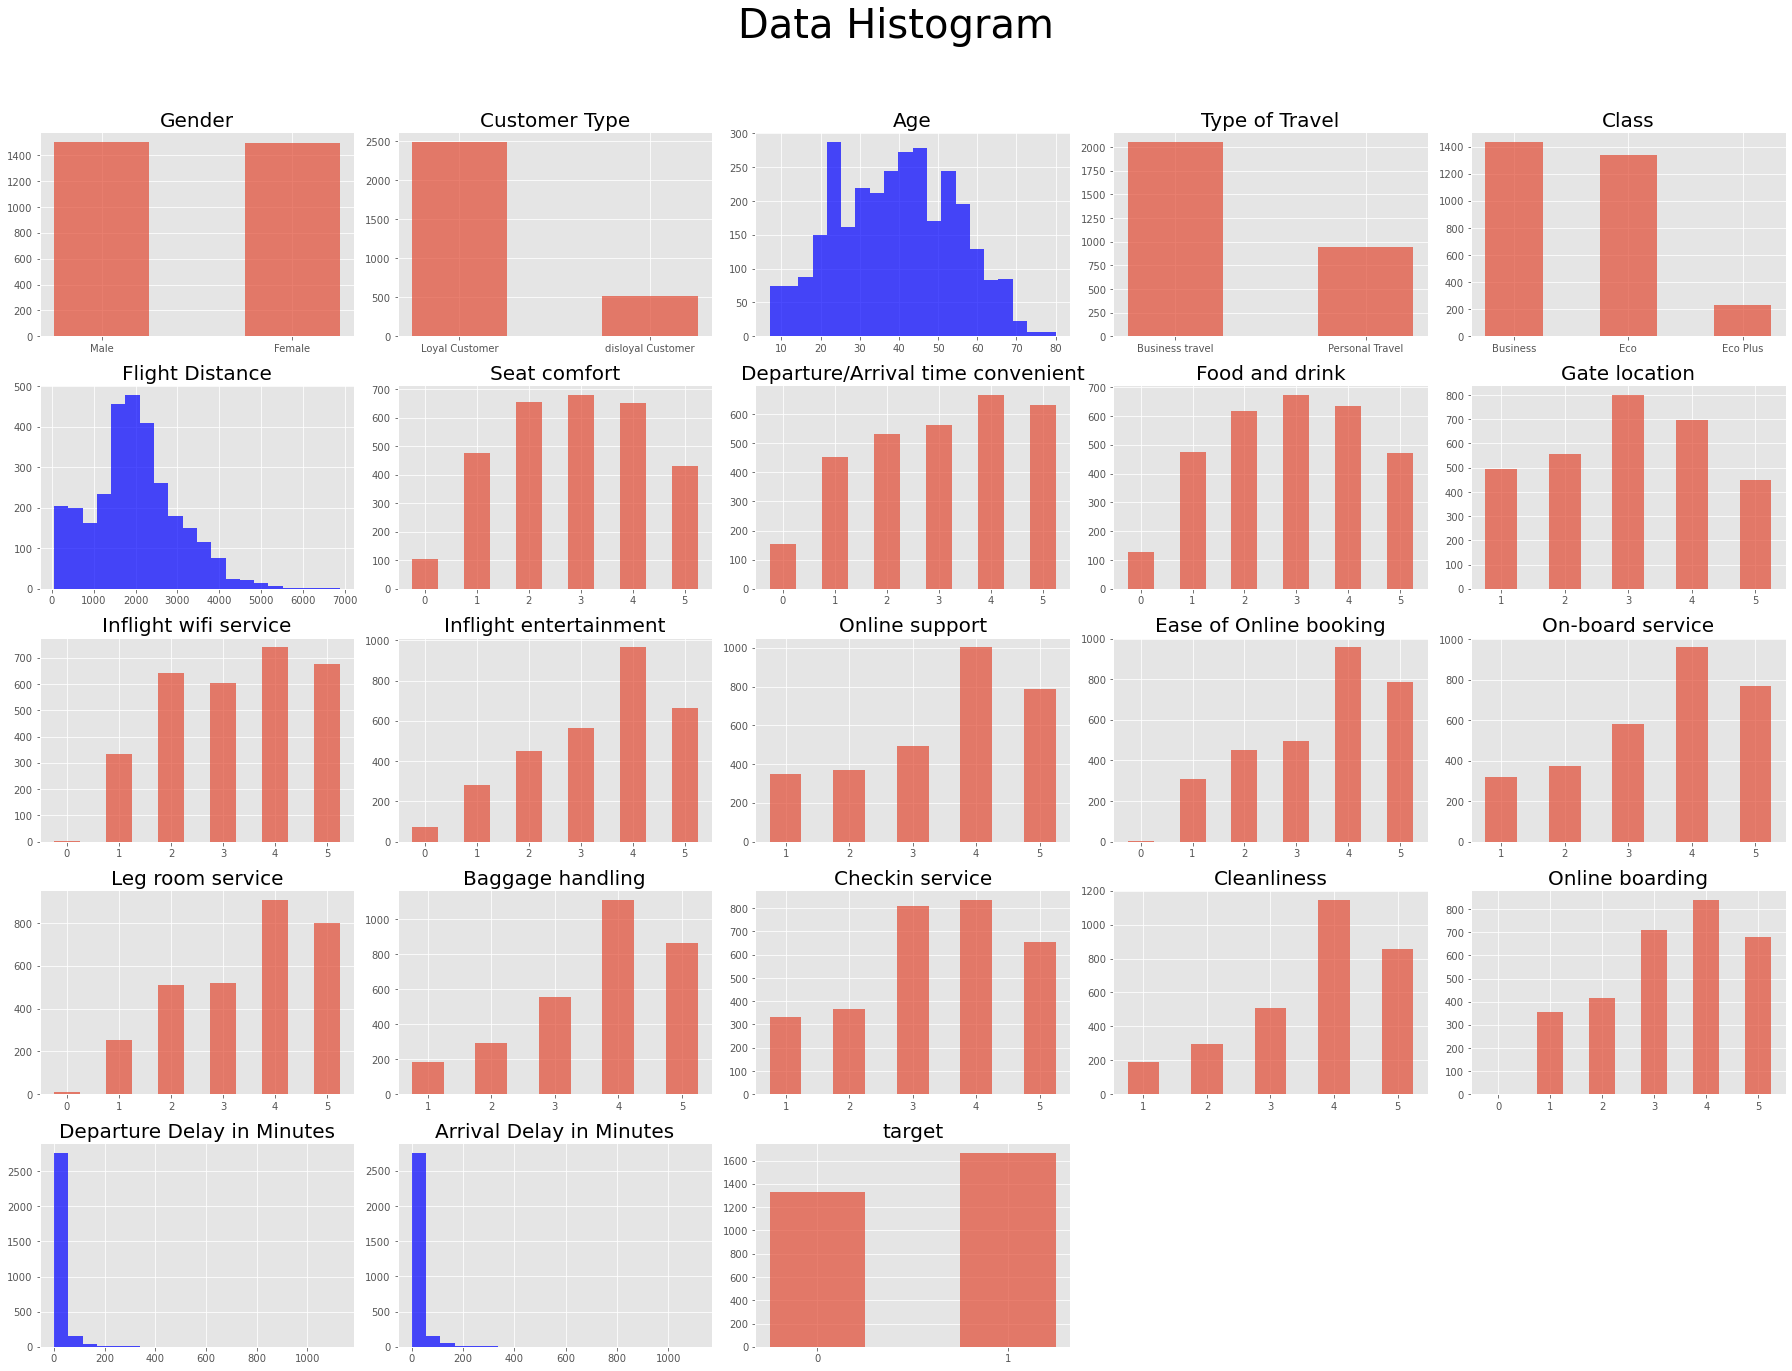

In [30]:
plt.style.use('ggplot')
## 히스토그램으로 보기
plt.figure(figsize=(25,20))
plt.suptitle('Data Histogram', fontsize=40)

## id 제외하고 시각화
cols = data.columns
for i in range(len(cols)):
    plt.subplot(5,5,i+1) # 5 by 5, 25개의 특징 분포 확인
    plt.title(cols[i], fontsize = 20) # 각 col별 타이틀
    if len(data[cols[i]].unique()) > 20 : # 컬럼 내에 고유 특징이 20개가 넘으면
        plt.hist(data[cols[i]], bins=20, color='b',alpha = 0.7) # 히스토그램 칸을 20으로 하는(bin) 히스토그램 출력 (alpha : 투명도)
    else:
        temp = data[cols[i]].value_counts() # 각 특징의 값 종류의 개수를 temp에 저장
        plt.bar(temp.keys(), temp.values, width=0.5, alpha = 0.7)        
        plt.xticks(temp.keys())
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

- 파란 그래프가 아닌 것은 2개 또는 5개 값으로 이루어져 있음
- 파란 그래프는 연속값,age를 제외하고 좌측으로 편향되어 있음

## target과 feature 관계확인

### 범주형

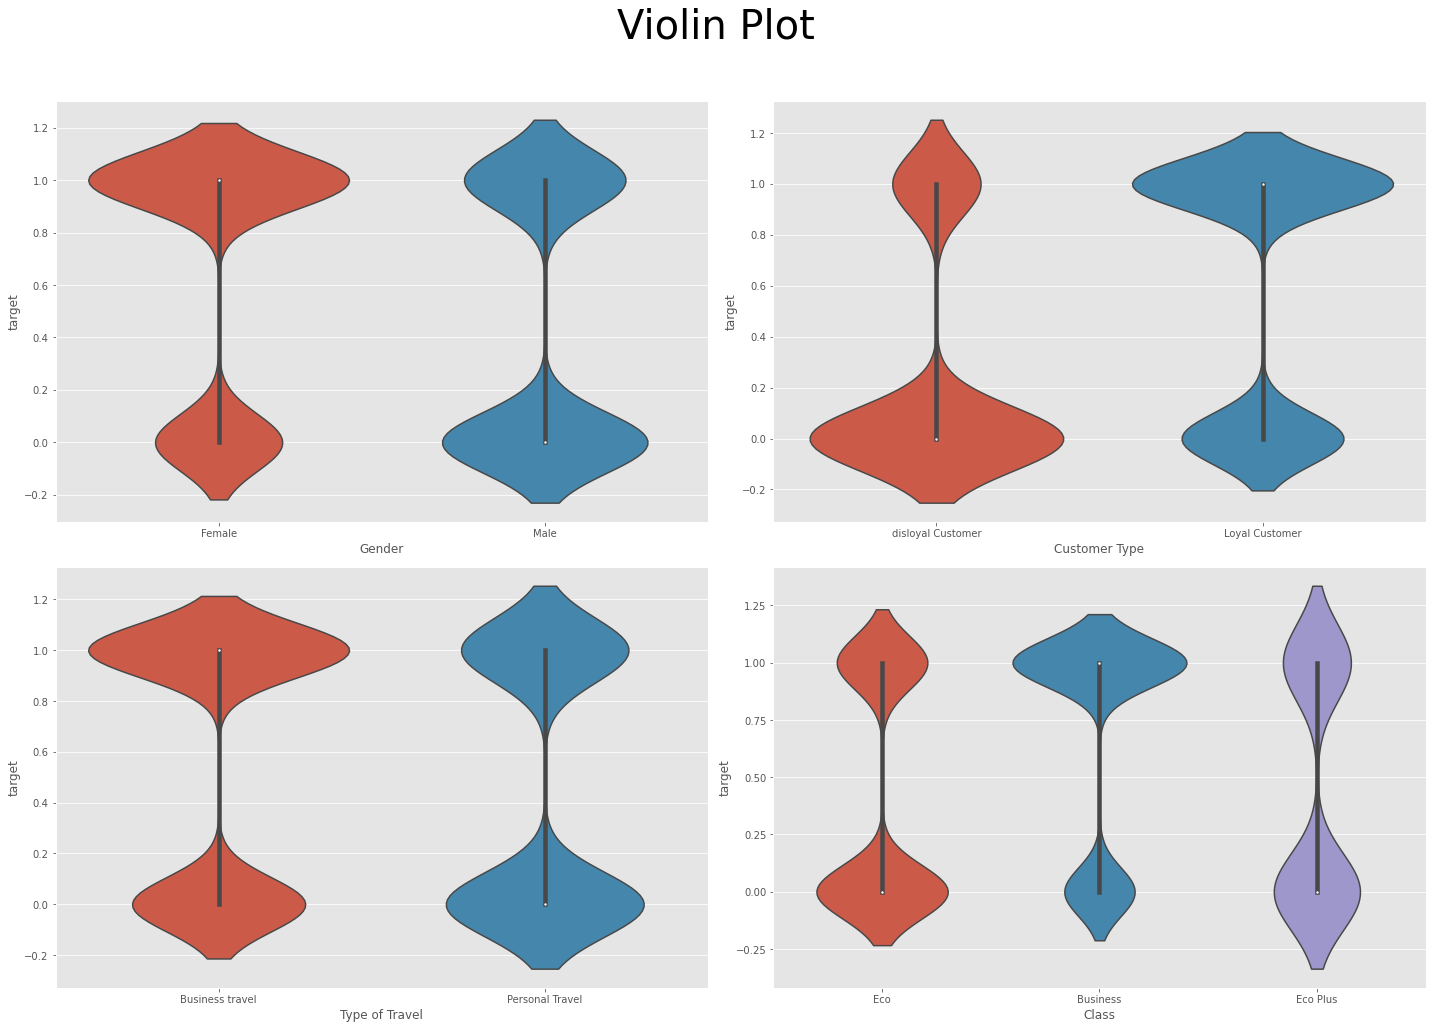

In [33]:
# 타겟 설정
target = 'target'
# 범주형 데이터 분리
categorical_feature = data.columns[data.dtypes == 'object']

plt.figure(figsize=(20,15))
plt.suptitle("Violin Plot", fontsize=40)

for i in range(len(categorical_feature)):
    plt.subplot(2,2,i+1)
    plt.xlabel(categorical_feature[i])
    plt.ylabel(target)
    sns.violinplot(data[categorical_feature[i]], y=data[target])
plt.tight_layout(rect=[0, 0.03, 1,0.95])
plt.show()

- 여성이 만족 점수가 남성보다 높은편
- disloyal과 loyal 편차가 큰편

### 수치형

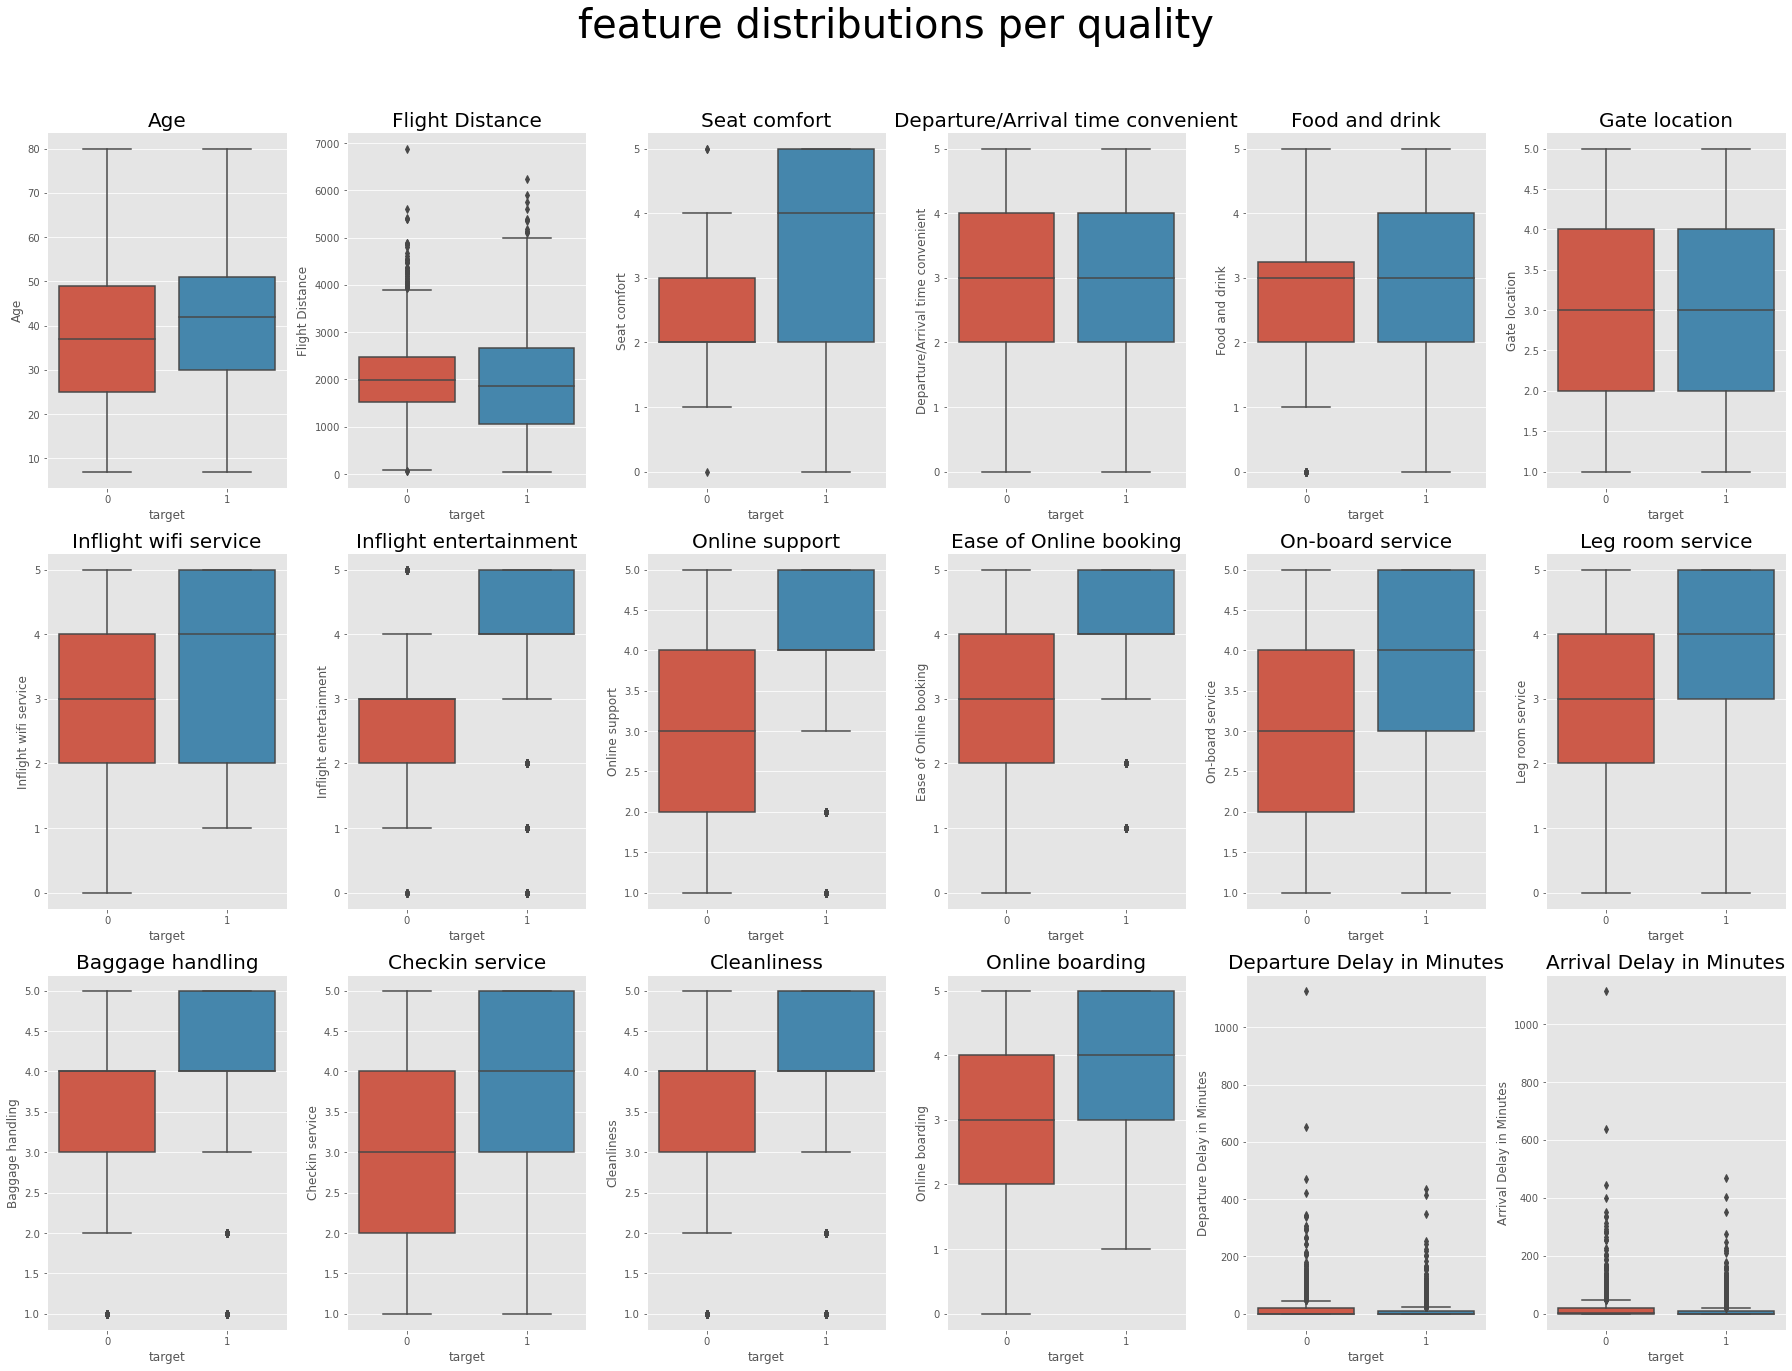

In [51]:
# 수치형 데이터 분리
numeric_feature = data.columns[(data.dtypes=='int64')|(data.dtypes=='float')]
num_data = data[numeric_feature]

# 박스 플롯
fig, axes = plt.subplots(3,6,figsize=(25,20))

fig.suptitle('feature distributions per quality', fontsize=40)
for ax,col in zip(axes.flat, num_data.columns[:-1]):  # target 제외
    sns.boxplot(x='target', y=col, ax=ax, data=num_data)
    ax.set_title(col,fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1,0.95])
plt.show()

- 박스 외에 있는 데이터는 이상치
- target을 구분하는 요인으로 0과 1에 고루 분포되어 있는 데이터는 중요하지 않다는 판단
- 따라서, Age/Departure Delay in Minutes, Arrival Delay in Minutes, Gate location 은 상관이 없어보임

## 상관계수 확인

### 범주형 데이터 label encoding

In [58]:
corr_df = data.copy()
corr_df[corr_df.columns[[corr_df.dtypes=='O']]] = corr_df[corr_df.columns[[corr_df.dtypes=='O']]].astype(str).apply(LabelEncoder().fit_transform)

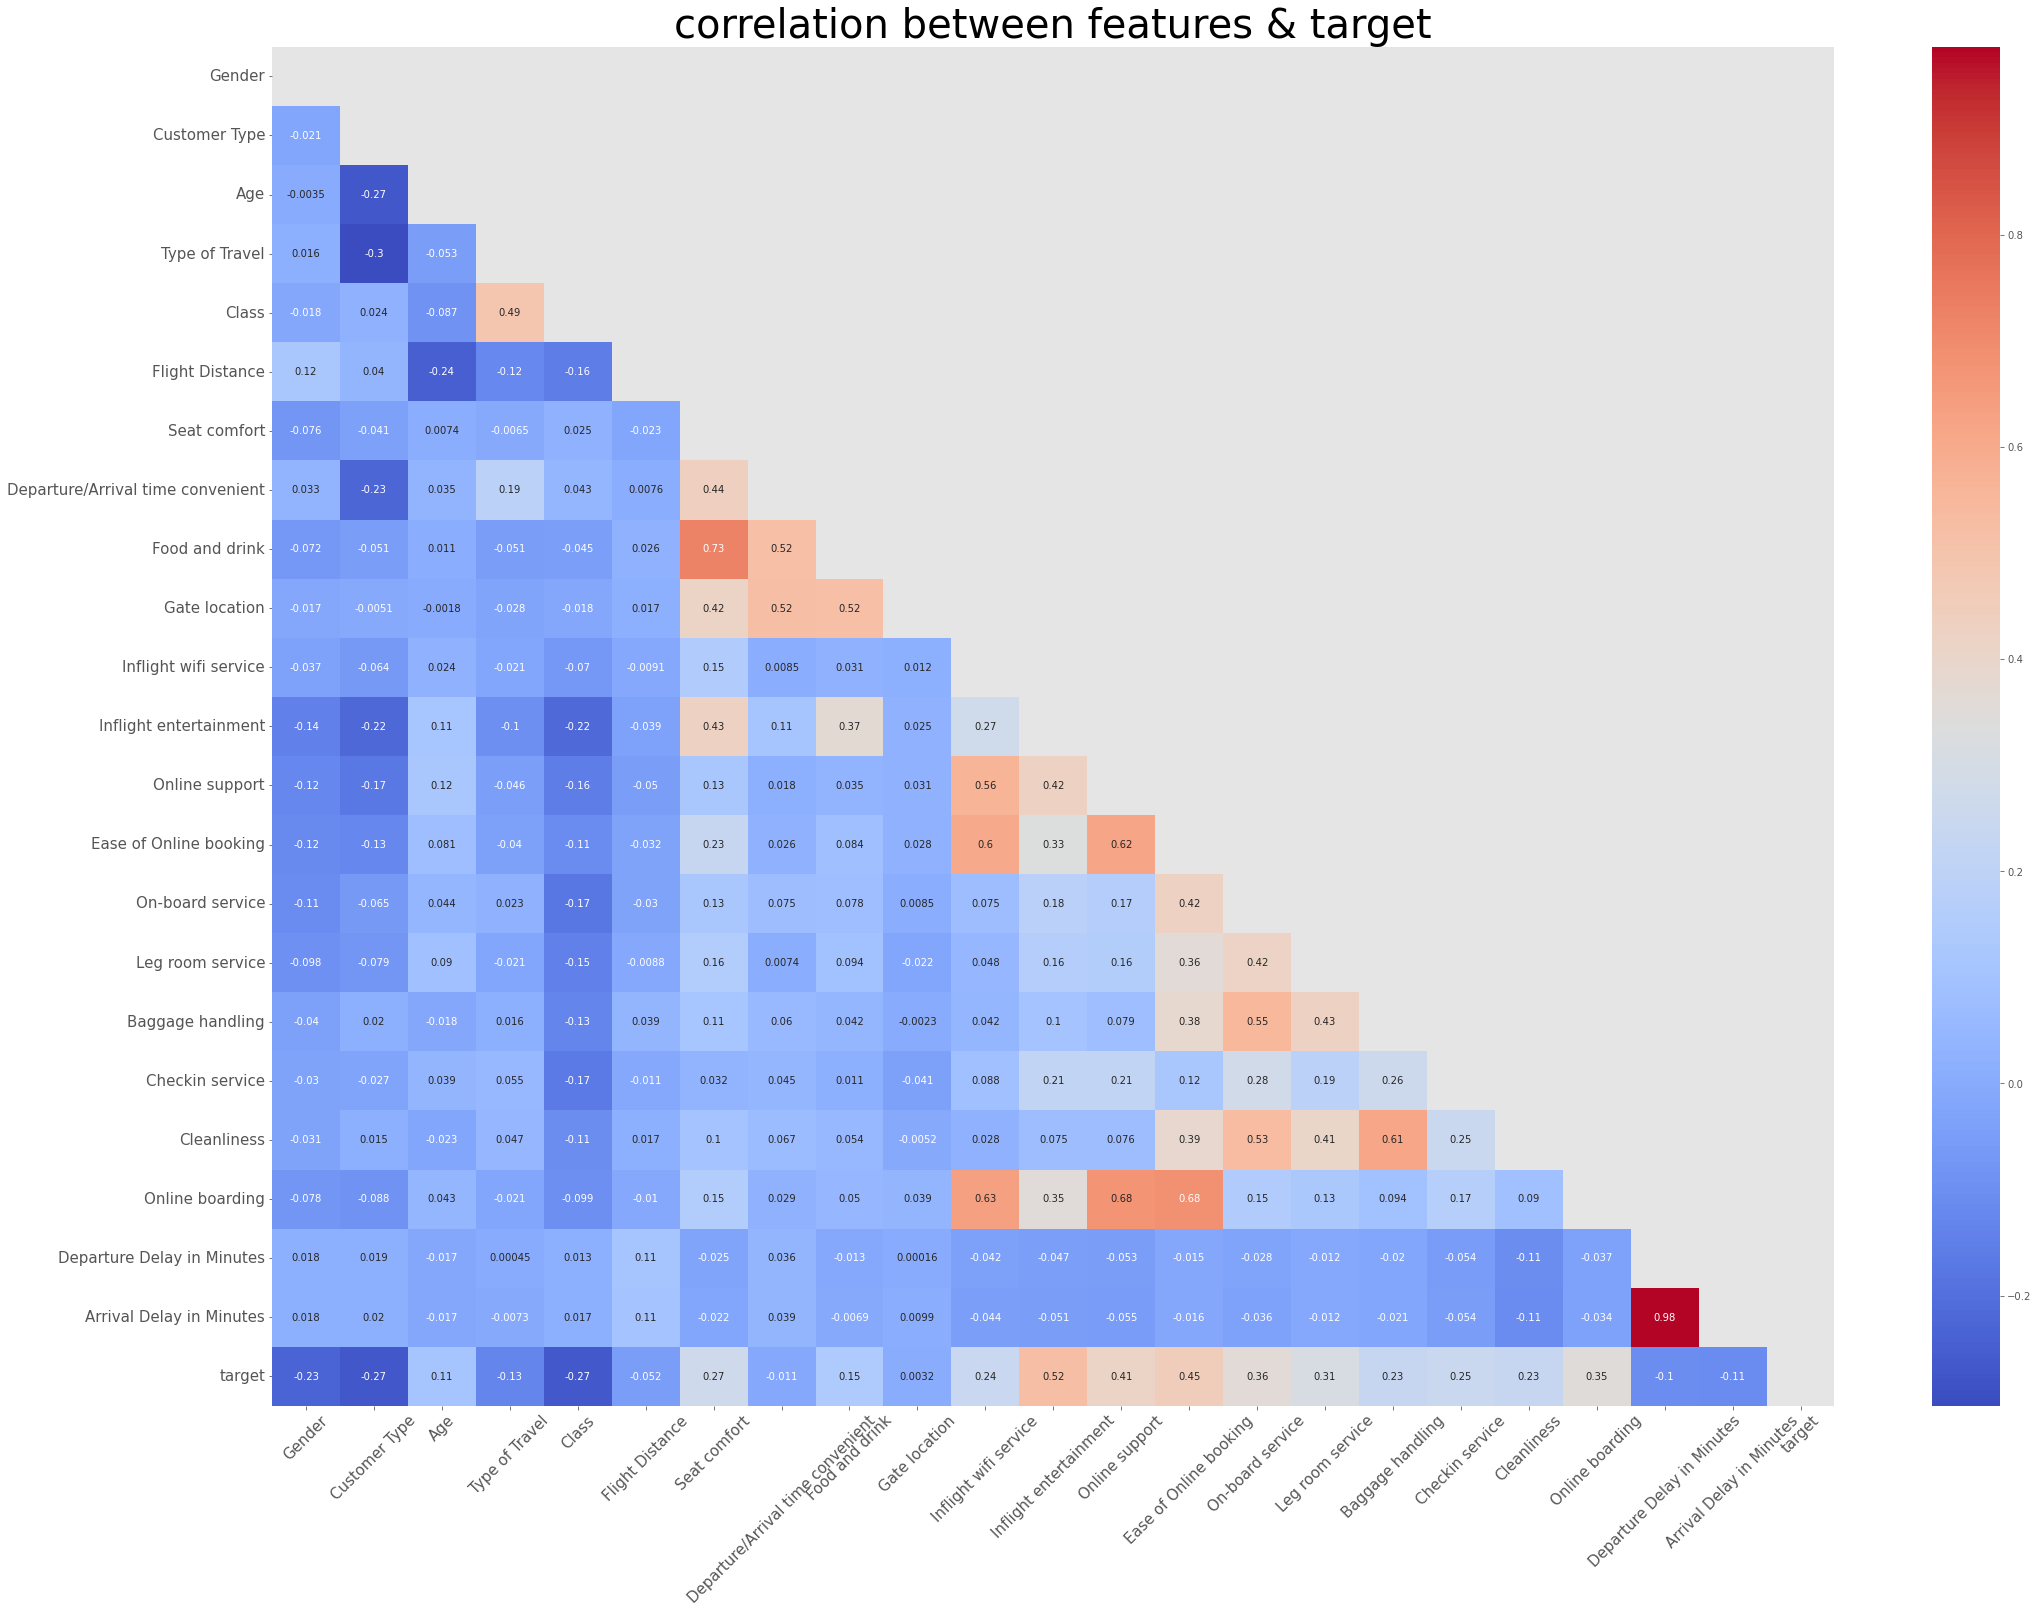

In [65]:
plt.figure(figsize=(35,25))

heat_table=corr_df.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask=mask, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features & target',fontsize=40)
plt.show()

- boxplot에서 확인한 것처럼 target과 상관관계가 낮은 데이터가 여럿 보인다
- 또한 다중공선성을 보이는 데이터들도 있어서 둘 중 상관관계 낮은 애를 지워주자

In [67]:
data.drop('Departure Delay in Minutes', axis = 1, inplace = True)
data.drop('Food and drink', axis = 1, inplace = True)
test.drop('Departure Delay in Minutes', axis = 1, inplace = True)
test.drop('Food and drink', axis = 1, inplace = True)

# 데이터 전처리

## 이상치 확인

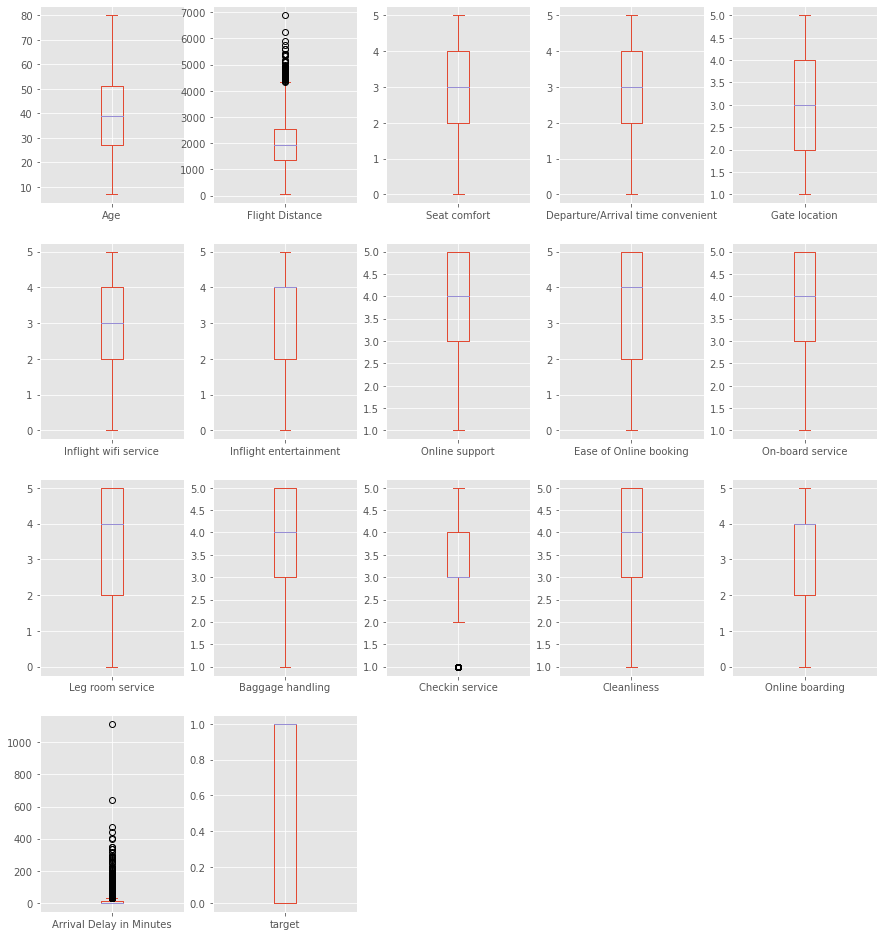

In [69]:
data.plot(kind='box', subplots=True, layout=(5,5), figsize=(15,21))
plt.show()

- 비행시간, 도착지연시간에 다수 분포
- 이상치를 평균치로 대체하자

### 이상치 인덱스 추출

In [72]:
def outliers_iqr(data):
    q1, q3 = np.percentile(data,[25,75])
    
    iqr = q3-q1
    lower_bound = q1 - (iqr*1.5)
    upper_bound = q3 + (iqr*1.5)
    
    return np.where((data > upper_bound)|(data < lower_bound))

In [73]:
ArrivalDelay_index_data = outliers_iqr(data['Arrival Delay in Minutes'])[0]
FlightDistance_index_data = outliers_iqr(data['Flight Distance'])[0]
GarageArea_index_data = outliers_iqr(data['Checkin service'])[0]
ArrivalDelay_index_data

array([   6,   23,   30,   35,   36,   51,   57,   59,   62,   66,   78,
         82,   85,   92,  116,  134,  137,  151,  160,  162,  175,  180,
        198,  202,  206,  214,  245,  255,  258,  279,  283,  285,  290,
        292,  303,  309,  315,  325,  335,  340,  341,  349,  359,  368,
        373,  375,  377,  385,  391,  394,  416,  428,  429,  435,  454,
        457,  472,  483,  484,  490,  510,  511,  517,  522,  537,  539,
        573,  575,  587,  592,  599,  604,  620,  621,  623,  627,  638,
        641,  650,  652,  653,  670,  672,  676,  693,  695,  696,  703,
        707,  715,  721,  723,  737,  752,  763,  766,  773,  774,  783,
        792,  797,  798,  799,  809,  810,  824,  837,  846,  852,  858,
        862,  869,  883,  884,  895,  904,  906,  912,  923,  937,  947,
        948,  949,  962,  968,  978,  983,  987,  993, 1001, 1002, 1013,
       1014, 1020, 1027, 1031, 1034, 1044, 1065, 1068, 1069, 1073, 1074,
       1098, 1103, 1116, 1122, 1140, 1151, 1152, 11

### 이상치 인덱스에 평균값 대입

In [75]:
data.loc[ArrivalDelay_index_data, 'Arrival Delay in Minutes'] = data['Arrival Delay in Minutes'].mean()
data.loc[FlightDistance_index_data, 'Flight Distance'] = data['Flight Distance'].mean()
data.loc[GarageArea_index_data, 'Checkin service'] = data['Checkin service'].mean()

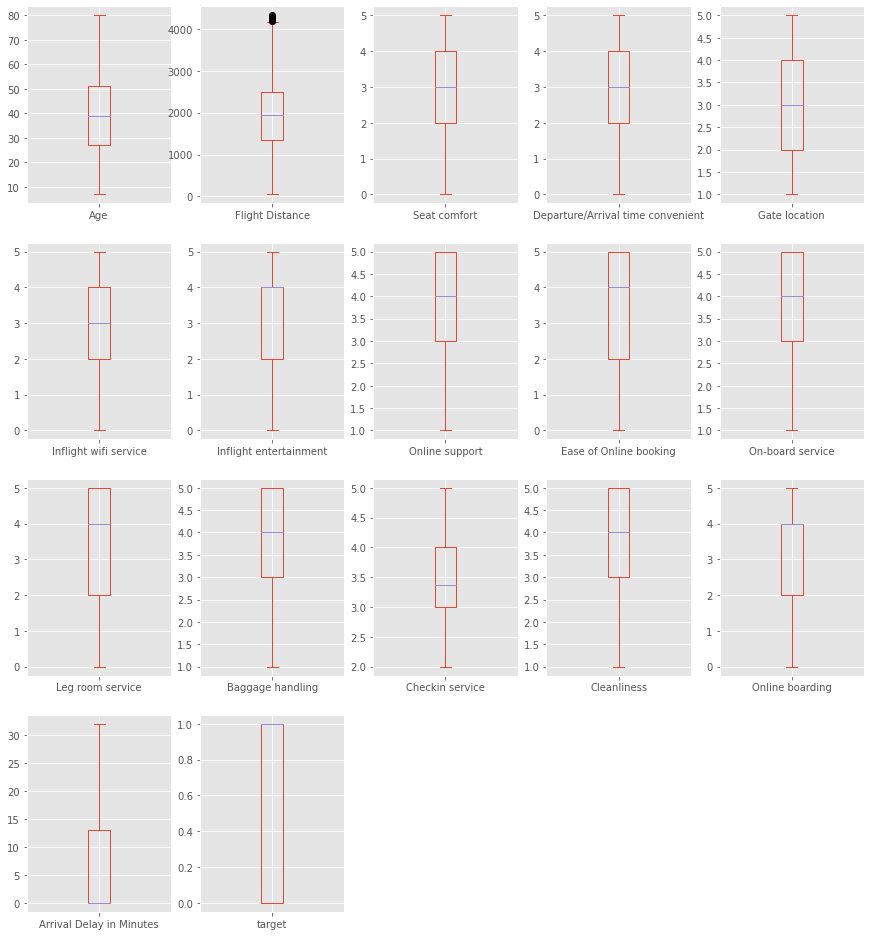

In [76]:
# 이상치 대치 확인
data.plot(kind='box', subplots=True, layout=(5, 5), figsize=(15, 21))
plt.show()       

In [77]:
# 테스트셋에도 적용
ArrivalDelay_index_test = outliers_iqr(test['Arrival Delay in Minutes'])[0]
FlightDistance_index_test = outliers_iqr(test['Flight Distance'])[0]
GarageArea_index_test = outliers_iqr(test['Checkin service'])[0]

test.loc[ArrivalDelay_index_test, 'Arrival Delay in Minutes'] = test['Arrival Delay in Minutes'].mean()
test.loc[FlightDistance_index_test, 'Flight Distance'] = test['Flight Distance'].mean()
test.loc[GarageArea_index_test, 'Checkin service'] = test['Checkin service'].mean()

## 범주형 데이터 라벨인코딩

In [78]:
# 데이터 셋
data[data.columns[data.dtypes=='O']] = data[data.columns[data.dtypes=='O']].astype(str).apply(LabelEncoder().fit_transform)

# 테스트 셋
test[test.columns[test.dtypes=='O']] = test[test.columns[test.dtypes=='O']].astype(str).apply(LabelEncoder().fit_transform)

# 모델링

In [81]:
# 여러 모델 비교
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [80]:
# 평가지표
def ACCURACY(true, pred):
    score = np.mean(true==pred)
    return score

## K-Fold, MinMaxsclar 사용

In [101]:
def kfold(model, train, scale = False):
    cv_accuracy = []
    cv = StratifiedKFold(n_splits=5)
    
    n_iter = 0
    
    for t, v in cv.split(train, train['target']):
        
        train_cv = train.iloc[t] # 훈련용
        val_cv = train.iloc[v] # 검증용 분리

        train_X = train_cv.drop('target', axis=1)
        train_y = train_cv['target']

        val_X = val_cv.drop('target', axis=1)
        val_y = val_cv['target']
            
        model.fit(train_X, train_y)
        score = ACCURACY(val_y, model.predict(val_X))
        
        cv_accuracy.append(score)
        n_iter += 1
    return np.mean(cv_accuracy)

In [102]:
models = [
    KNeighborsClassifier(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=20, n_estimators=300),
    GradientBoostingClassifier(),
    XGBClassifier(eval_metric = 'logloss',
                  max_depth = 5,
                  min_chile_weight = 3,
                  gamma = 3,
                  colsample_bytree = 0.5,
                  n_estimators=700),
    LGBMClassifier(n_estimators=600, max_bin=400, num_leaves=24),
    CatBoostClassifier(silent=True, depth=6, l2_leaf_reg=7, learning_rate=0.1, n_estimators=500),
    ExtraTreesClassifier(max_depth=25, n_estimators=320)
]

print('스케일링 적용 전')
for model in models:
    print(f'{type(model).__name__}score:{kfold(model, data)}')

스케일링 적용 전
KNeighborsClassifierscore:0.6056666666666667
LogisticRegressionscore:0.8119999999999999
DecisionTreeClassifierscore:0.8746666666666668
RandomForestClassifierscore:0.8969999999999999
GradientBoostingClassifierscore:0.9123333333333333
[12:45:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { min_chile_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:45:14] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { min_chile_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to 

## 모델 튜닝

### RF

In [103]:
params = { 'n_estimators' : [10, 100, 1000],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

In [104]:
train = data.drop('target',axis=1)
target = data['target']

model_RFC = RandomForestClassifier()
grid_cv_RFC = GridSearchCV(model_RFC, param_grid = params, cv=5, n_jobs = -1)
grid_cv_RFC.fit(train, target) # train과 target은 위에 train_test_split하기 전에 있었음

print('최적 하이퍼 파라미터: ', grid_cv_RFC.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv_RFC.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
최고 예측 정확도: 0.8983


## 모델 앙상블, soft voting

In [105]:
model_XGB = XGBClassifier(eval_metric='logloss', silent = True)

param_grid={'booster' :['gbtree'],
                 'silent':[True],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['binary:logistic'],
                 'random_state':[2]}

grid_cv_XGB=GridSearchCV(model_XGB, param_grid=param_grid, cv=5 , n_jobs=-1)
grid_cv_XGB.fit(train, target)
print('최적 하이퍼 파라미터: ', grid_cv_XGB.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv_XGB.best_score_))

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anaconda3/envs/ppangppang/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/ppangppang/opt/anacon

[13:13:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


최적 하이퍼 파라미터:  {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 2, 'silent': True}
최고 예측 정확도: 0.9360


In [106]:
model_LGBM = LGBMClassifier()

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [100, 500, 1000],
    'num_leaves': [12, 16, 20], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[300, 600], # large max_bin helps improve accuracy but might slow down training progress
    }

grid_cv_LGBM = GridSearchCV(model_LGBM, param_grid=gridParams, cv=3 , n_jobs=-1)
grid_cv_LGBM.fit(train, target)
print('최적 하이퍼 파라미터: ', grid_cv_LGBM.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv_LGBM.best_score_))

최적 하이퍼 파라미터:  {'boosting_type': 'dart', 'learning_rate': 0.01, 'max_bin': 300, 'n_estimators': 1000, 'num_leaves': 20, 'objective': 'binary'}
최고 예측 정확도: 0.9107


In [107]:
model_CAT = CatBoostClassifier(silent = True)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_cv_CAT = GridSearchCV(model_CAT, param_grid=grid, cv=3 , n_jobs=-1)
grid_cv_CAT.fit(train, target)
print('최적 하이퍼 파라미터: ', grid_cv_CAT.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv_CAT.best_score_))


최적 하이퍼 파라미터:  {'depth': 6, 'l2_leaf_reg': 7, 'learning_rate': 0.03}
최고 예측 정확도: 0.9403


## soft voting

In [110]:
best_model_XGB = XGBClassifier(eval_metric = 'logloss', \
                              silent = True, \
                              max_depth = 5, \
                              min_child_weight = 3, \
                               gamma = 3, \
                               colsample_bytree = 0.5, \
                               n_estimators=700)
best_model_LGBM = LGBMClassifier(n_estimators=600, max_bin=400, num_leaves=24)
best_model_CAT = CatBoostClassifier(silent=True, depth=6, l2_leaf_reg=7, learning_rate=0.1, n_estimators=500)
best_model_EXTRA = ExtraTreesClassifier(max_depth=25, n_estimators=320)

from sklearn.ensemble import VotingClassifier
softVoting_model = VotingClassifier(estimators=[('XGB', best_model_XGB), ('LGBM', best_model_LGBM), ('CAT', best_model_CAT), ('EXTRA', best_model_EXTRA)], voting='soft') 
softVoting_model.fit(train, target)

[13:29:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




VotingClassifier(estimators=[('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            eval_metric='logloss', gamma=3,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=5,
                                            min_child_weight=3, missing=nan,
                                            monotone_constraints=None,
                                            n_e...
                                            random_state=None, reg_alpha=None,
                                    

(array([ 910.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1090.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

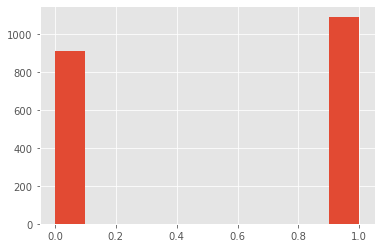

In [111]:
soft_pred = softVoting_model.predict(test)
plt.hist(soft_pred)

In [116]:
submission.target = soft_pred

In [117]:
submission.to_csv(path+'submissions/submission10.csv',index=False)